# Logistic Regression

* Logistic Regression (also called **Logit Regression**) is commonly used to estimate the probability that an instance belongs to a particular class.
* Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result

$$\hat{p} = h_{\theta}(x) = \sigma(x^{T}\theta)$$

$$$$
$$\sigma(t) = \dfrac{1}{1 + \exp(-t)}$$


## Logistic Regression model prediction

$$\hat{h}= \left\{ \begin{array}{rcl}  0 & \mbox{if} & \hat{p} < 0.5 \\ 1 & \mbox{if} & \hat{p} \geq 0.5 \end{array}\right.$$

## Cost function

* Cost function of a single training instance: 

$$c(\theta) = \left\{ \begin{array}{rcl} -\log{(\hat{p})} & \mbox{if} & y=1 \\ -\log(1 - \hat{p}) & \mbox{if} & y=0\end{array}\right.$$

* Cost function for logistic regression(log loss):

$$J(\theta) = -\dfrac{1}{m} * \sum_{i=1}^{m} \left[y^{(i)}\log(\hat{p}) +  ({1-y^{(i)}})\log({1-\hat{p}})\right]$$

$$ \frac{\partial}{\partial \theta_{j}} J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left( \sigma\left( \theta^{T}x^{i}\right)- y^{i}\right)x^{(i)}_{j}$$


In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from jax import random
from sklearn import datasets
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 132
key = random.PRNGKey(seed=seed)

# Logistic Regression Class

In [3]:
class LogisticRegression:
    def __init__(
        self, 
        key: jnp.ndarray, 
        lr: float=0.01, 
        epochs: int=10, 
        batch_size: int=32,
        multi_class: bool=False):
        
        self.key = key
        self.init_lr = lr
        self.decay = 0.001
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_progress = []
        self.train_acc = []
        self.scheduler_progress = []
        self.multi_class = multi_class
    
    def learning_schedule(self, steps):
        curr_lr = self.init_lr / (1. + self.decay * steps)
        self.scheduler_progress.append(curr_lr)
        return curr_lr

    def fit(self, X, y):
        num_samples = X.shape[0]
        num_features = X.shape[1]
        
        
        X = jnp.hstack((jnp.ones((num_samples, 1)), X)) # (add column for bias term which will be one)
        y = jnp.squeeze(y)
        
        num_classes = jnp.unique(y_train).shape[0]
        
        # When you have more than two classes we will do one hot encoding the labels
        if num_classes > 2:
            y = jax.nn.one_hot(y, num_classes) # Ensure y has shape (num_samples, num_classes)
            self.W = random.normal(self.key, shape=(num_features + 1, num_classes)) # (num_features + bias term, num_classes)
        else:
            y = y.reshape(-1, 1)  # Ensure y has shape (num_samples, 1)
            self.W = random.normal(self.key, shape=(num_features + 1, 1)) # (num_features + bias term, num_classes)
            
        batch_comp = (num_samples // self.batch_size) * self.batch_size
        
        if num_samples != batch_comp:
            X_main, y_main = X[:batch_comp, :], y[:batch_comp, :]
            X_rem, y_rem = X[batch_comp:, :], y[batch_comp:, :]
        else:
            X_main, y_main = X, y
            X_rem, y_rem = None, None
        
        X_batched = X_main.reshape(num_samples// self.batch_size, self.batch_size, -1)
        y_batched = y_main.reshape(num_samples// self.batch_size, self.batch_size, -1)
        
        
        for epoch in range(self.epochs):
            epoch_loss = []
            epoch_acc = []
            for step, (X_batch, y_batch) in enumerate(zip(X_batched, y_batched)):
                # Forward Pass
                if not self.multi_class:
                    y_pred = jax.nn.sigmoid(X_batch @ self.W)  # (num_samples, num_features + 1) @ (num_features + 1, 1) -> (num_samples, 1)
                else:
                    y_pred = jax.nn.softmax(X_batch @ self.W)

                # Calculate Gradient
                # (num_features + 1, num_samples) @ (num_samples, num_classes) -> (num_features + 1, num_classes)
                dW = (1 / self.batch_size) * (X_batch.T @ (y_pred - y_batch))

                # For each batch now we calculate learning schedule using a scheduler
                # we decay with batch consider 0.1 * (1 / (1 + 0.001 * num_steps))
                num_steps = (num_samples // self.batch_size) * epoch + step
                self.lr = self.learning_schedule(num_steps)

                # Update Weights
                self.W -= self.lr * dW

                # Append Batch Loss
                if not self.multi_class:
                    log_loss = - (1/self.batch_size) * jnp.sum((y_batch * jnp.log(y_pred) + (1 - y_batch) * jnp.log(1 - y_pred)))
                else:
                    log_loss = - (1/self.batch_size) * jnp.sum(jnp.sum(y_batch * jnp.log(y_pred), axis=1))
                epoch_loss.append(log_loss)
                
                # calculate batch accuracy
                if not self.multi_class:
                    batch_acc = (jnp.where(y_pred >= 0.5, 1, 0) == y_batch).sum() / self.batch_size
                else:
                    y_pred = jnp.argmax(y_pred, axis=1)
                    y_batch = jnp.argmax(y_batch, axis=1)
                    batch_acc = (y_pred == y_batch).sum() / self.batch_size
                
                epoch_acc.append(batch_acc)

                # Now we have to update the weights also for last batch of data which was
                # not catered when batching the data because of the data size not divisible
                # by the batch size
                if X_rem is not None:
                    if not self.multi_class:
                        y_pred = jax.nn.sigmoid(X_rem @ self.W)
                    else:
                        y_pred = jax.nn.softmax(X_rem @ self.W)
                        
                    dW =  (1 / X_rem.shape[0]) * (X_rem.T @ (y_pred - y_rem))
                    # Update Weights, consider the last few samples under last batch and 
                    # update with same learning rate
                    self.W -= self.lr * dW 
                    if not self.multi_class:
                        log_loss = - (1 / X_rem.shape[0]) * jnp.sum((y_rem * jnp.log(y_pred) + (1 - y_rem) * jnp.log(1 - y_pred)))
                    else:
                        log_loss = - (1 / X_rem.shape[0]) * jnp.sum(jnp.sum(y_rem * jnp.log(y_pred), axis=1))
            
                    epoch_loss.append(log_loss)
                    if not self.multi_class:
                        batch_acc = (jnp.where(y_pred >= 0.5, 1, 0) == y_rem).sum() / X_rem.shape[0]
                    else:
                        y_pred = jnp.argmax(y_pred, axis=1)
                        y_rem_cat = jnp.argmax(y_rem, axis=1)
                        batch_acc = (y_pred == y_rem_cat).sum() / X_rem.shape[0]
                    epoch_acc.append(batch_acc)
                 
            
            # Calculate Average Loss after each epoch
            loss = np.mean(epoch_loss)
            acc = np.mean(epoch_acc)
            
            self.train_acc.append(acc)
            self.loss_progress.append(loss)
            print(f"Epoch {epoch + 1}: Loss: {loss}, Accuracy: {acc:.2f}%")
        
    def predict(self, X):
        X = jnp.hstack((jnp.ones(shape=(X.shape[0], 1)), X))  # Add bias term
        return jax.nn.sigmoid(X @ self.W)
        
        

# Load IRIS dataset with one class

In [4]:
iris = datasets.load_iris()
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(int) # 1 if Iris-Virginica, else 0

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=seed, test_size=0.3)

# Train the Logistic Regression Model

In [5]:
logistic_regression = LogisticRegression(
    key,
    lr=0.1,
    epochs=50,
    batch_size=16
)

In [6]:
logistic_regression.fit(
    X_train, y_train)

Epoch 1: Loss: 0.9007863402366638, Accuracy: 0.47%
Epoch 2: Loss: 0.8482303023338318, Accuracy: 0.47%
Epoch 3: Loss: 0.8019809126853943, Accuracy: 0.47%
Epoch 4: Loss: 0.7606083750724792, Accuracy: 0.54%
Epoch 5: Loss: 0.7233477234840393, Accuracy: 0.70%
Epoch 6: Loss: 0.6897023320198059, Accuracy: 0.77%
Epoch 7: Loss: 0.6592811942100525, Accuracy: 0.77%
Epoch 8: Loss: 0.6317437887191772, Accuracy: 0.77%
Epoch 9: Loss: 0.6067824959754944, Accuracy: 0.77%
Epoch 10: Loss: 0.584118664264679, Accuracy: 0.77%
Epoch 11: Loss: 0.563500165939331, Accuracy: 0.77%
Epoch 12: Loss: 0.5447013974189758, Accuracy: 0.77%
Epoch 13: Loss: 0.5275210738182068, Accuracy: 0.77%
Epoch 14: Loss: 0.5117807388305664, Accuracy: 0.77%
Epoch 15: Loss: 0.4973228871822357, Accuracy: 0.77%
Epoch 16: Loss: 0.48400869965553284, Accuracy: 0.77%
Epoch 17: Loss: 0.4717160761356354, Accuracy: 0.77%
Epoch 18: Loss: 0.46033796668052673, Accuracy: 0.77%
Epoch 19: Loss: 0.4497798979282379, Accuracy: 0.77%
Epoch 20: Loss: 0.439

# Predicton on Validation Set

In [7]:
y_pred = logistic_regression.predict(X_val)

val_acc = ((y_pred >= 0.5)[:, 0] == y_val).sum() / X_val.shape[0]

print(f"Validation Accuracy: {val_acc: .2f}")

Validation Accuracy:  0.91


# Loss and Accuracy Curves

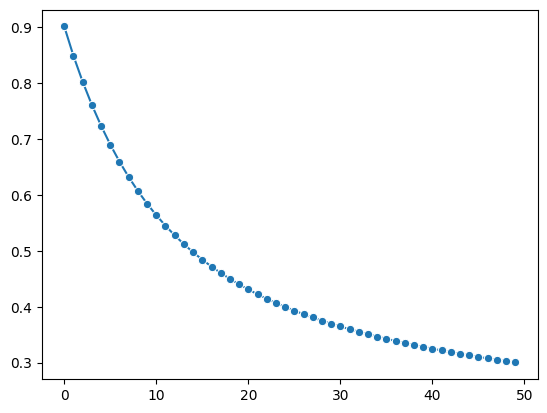

In [8]:
sns.lineplot(logistic_regression.loss_progress, marker='o')
plt.show()
plt.show()

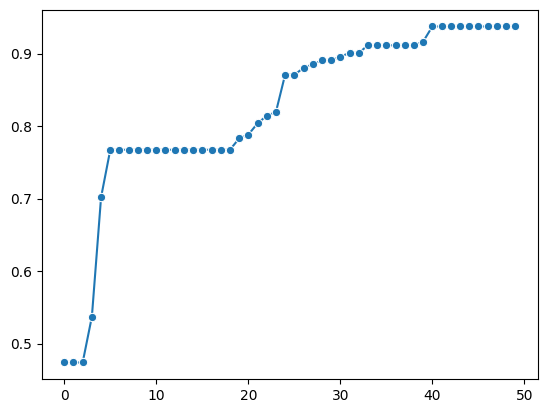

In [9]:
sns.lineplot(logistic_regression.train_acc,  marker='o')
plt.show()

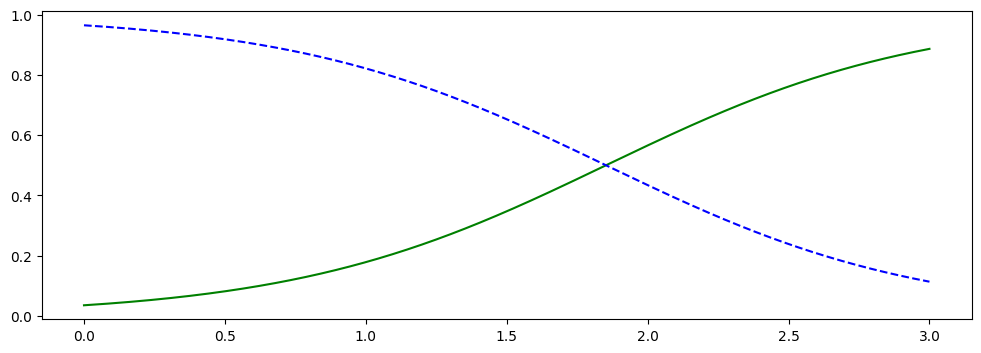

In [10]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = logistic_regression.predict(X_new)
plt.figure(figsize=(12, 4))
plt.plot(X_new, y_proba[:, 0], "g-", label="Iris-Virginica")
plt.plot(X_new, 1 - y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.show()

# Let's train with all classes and features

In [11]:
X = iris["data"] 
y = (iris["target"]).astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=seed, test_size=0.2)

# Basically here the activation will be softmax which will be help us optimize for multi-class

In [12]:
logistic_regression = LogisticRegression(
    key,
    lr=0.1,
    epochs=30,
    batch_size=16,
    multi_class=True
)

# Loss and Accuracy Curves

In [13]:
logistic_regression.fit(X_train, y_train)

Epoch 1: Loss: 2.0844907760620117, Accuracy: 0.56%
Epoch 2: Loss: 0.8838008046150208, Accuracy: 0.62%
Epoch 3: Loss: 0.7433382868766785, Accuracy: 0.66%
Epoch 4: Loss: 0.6358753442764282, Accuracy: 0.68%
Epoch 5: Loss: 0.5504477024078369, Accuracy: 0.73%
Epoch 6: Loss: 0.48418307304382324, Accuracy: 0.76%
Epoch 7: Loss: 0.43404528498649597, Accuracy: 0.78%
Epoch 8: Loss: 0.3957900106906891, Accuracy: 0.80%
Epoch 9: Loss: 0.36575791239738464, Accuracy: 0.82%
Epoch 10: Loss: 0.3414440155029297, Accuracy: 0.84%
Epoch 11: Loss: 0.32123228907585144, Accuracy: 0.86%
Epoch 12: Loss: 0.30407100915908813, Accuracy: 0.86%
Epoch 13: Loss: 0.289254754781723, Accuracy: 0.86%
Epoch 14: Loss: 0.27629315853118896, Accuracy: 0.88%
Epoch 15: Loss: 0.2648329436779022, Accuracy: 0.89%
Epoch 16: Loss: 0.2546113431453705, Accuracy: 0.89%
Epoch 17: Loss: 0.24542680382728577, Accuracy: 0.90%
Epoch 18: Loss: 0.23712165653705597, Accuracy: 0.90%
Epoch 19: Loss: 0.2295697033405304, Accuracy: 0.91%
Epoch 20: Loss

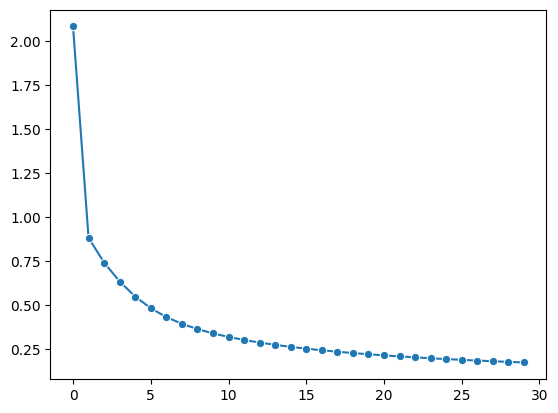

In [14]:
sns.lineplot(logistic_regression.loss_progress, marker='o')
plt.show()
plt.show()

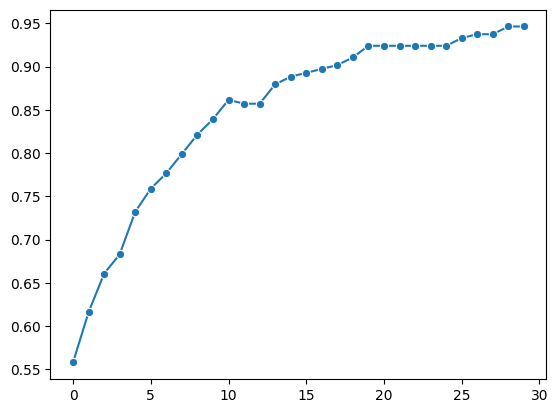

In [15]:
sns.lineplot(logistic_regression.train_acc,  marker='o')
plt.show()

# References

1. [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975/ref=asc_df_1098125975/?tag=hyprod-20&linkCode=df0&hvadid=564681728094&hvpos=&hvnetw=g&hvrand=12536021134787862812&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9061321&hvtargid=pla-1651497364252&psc=1&mcid=ee20b34166b93f94b9a88a727e2204b3&gclid=CjwKCAjwt-OwBhBnEiwAgwzrUvy6fyRVoCj9LZC1E4kgyL5KvZKoFNJFSWa2nRThyPByYb_YQCTPERoCVQsQAvD_BwE)